# Lab 11 Images - Exercises

These are some imports. You can skip this part.

In [ ]:
%matplotlib inline
import math
from IPython.display import display, HTML
from skimage import data, io, filters, exposure
from skimage import util
from skimage.color import rgb2hsv, hsv2rgb, rgb2gray
from skimage.filters import gabor_kernel
from skimage.measure import moments, moments_central, moments_normalized, moments_hu
import numpy as np
from skimage.transform import resize
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.signal import fftconvolve
from scipy.ndimage import center_of_mass
from scipy import spatial
from pylab import *
import random

The LabImage class is used in this notebook to keep a data of an image. It contains the following fields:<br>
a) img : an image object (numpy array),<br>
b) ID : name of a file,<br>
c) featuresValues: a feature vector. Each value of the feature vector corresponds to one predefined feature (characteristic/property of the image).<br>

In [ ]:
class LabImage:
    def __init__(self, img, ID):
        self.img = img
        self.ID = str(ID)
        self.featuresValues = []

The class Exercise maintains all data and provides methods for: loading images, displaying images end their characteristics, and searching for the most similar images of the collection to the provided query (image). You do not need to read the code. During the following exercises, you will be asked to implement (override) only two methods: functionOfSImilarity (it computes a similarity between two provided feature vectors) and featuresExtractor (it constructs a feature vector). 

In [3]:
class Exercise:
    def __init__(self, folderPath, featuresNames = None, featuresExtractor = None):
        self.images = []
        self.featuresNames = []
        self.featuresExtractor = featuresExtractor
        self.loadAndCompute(folderPath, featuresNames, featuresExtractor)
        self.folderPath = folderPath
        
    def loadAndCompute(self, folderPath, featuresNames = None, featuresExtractor = None):
        collection = io.imread_collection(folderPath + "*.jpg")
        self.images = [LabImage(collection[i], collection.files[i]) for i in range(0, len(collection))]
        if featuresNames is not None:
            self.featuresNames = featuresNames
        if featuresExtractor is not None:
            for image in self.images:
                image.featuresValues = featuresExtractor(image.img)
                
    def searchForImage(self, folderPath, fileName, functionOfSImilarity, scale = 1.0,):
        queryImage = LabImage(io.imread(folderPath + fileName), fileName)
        queryImage.featuresValues = self.featuresExtractor(queryImage.img)
        orderedIDs = [i for i in range(0, len(self.images))]
        similarities = [functionOfSImilarity(queryImage.featuresValues, image.featuresValues) 
                        for image in self.images]
        
        tmp = list(zip(orderedIDs, similarities))
        tmp.sort(key = lambda x: x[1], reverse = True)
        orderedIDs, similarities = zip(*tmp)
        ### DISPLAY QUERY
        figure(figsize=(5.0 * scale, 5.0 * scale), dpi=80)
        subplot(1, 1, 1); plt.imshow(queryImage.img)
        plt.show()
        print(queryImage.ID)
        #features 
        data = []
        for j in range(0, len(self.featuresNames)):
            if isinstance(queryImage.featuresValues, np.ndarray): 
                fV = []
                fV.append("- "+ self.featuresNames[j])
                fV.append("NaN")
                data.append(fV)
            else:
                fV = []
                fV.append("- "+ self.featuresNames[j])
                fV.append("{:10.2f}".format(queryImage.featuresValues[j]))
                data.append(fV)
        
        col_width = max(len(word) for row in data for word in row) + 5 # PADDING
        for row in data:
            print("".join(word.ljust(col_width) for word in row))
        ### DISPLAY RESULTS
        self.display(scale = scale, orderedIDs = orderedIDs, similarities = similarities)
    
    def printStats(self, lIMG, rIMG, orderedIDs = [], similarities = []):
        data = []
        # names
        names = []
        for i in range(lIMG, rIMG):
            names.append(self.images[orderedIDs[i]].ID[len(self.folderPath):])
            names.append(" ")
        data.append(names)
        # similarities
        if len(similarities) > 0:
            sim = []
            for i in range(lIMG, rIMG):
                sim.append("Similarity")
                sim.append("{:10.2f}".format(similarities[i]))
            data.append(sim)
        #features 
        for j in range(0, len(self.featuresNames)):
            if isinstance(self.images[orderedIDs[i]].featuresValues, np.ndarray):
                fV = []
                for i in range(lIMG, rIMG):
                    fV.append("- "+ self.featuresNames[j])
                    fV.append("NaN")
                data.append(fV)         
            else:
                fV = []
                for i in range(lIMG, rIMG):
                    fV.append("- "+ self.featuresNames[j])
                    fV.append("{:10.2f}".format(self.images[orderedIDs[i]].featuresValues[j]))
                data.append(fV)
        
        col_width = max(len(word) for row in data for word in row) + 5 # PADDING
        for row in data:
            print("".join(word.ljust(col_width) for word in row))
            
    def display(self, scale = 1.0, orderedIDs = [], similarities = []):
        div = 3
        h = (len(self.images))/div
        if len(orderedIDs) == 0:
            orderedIDs = [i for i in range(0, len(self.images))]
        for i in range(0, math.ceil(h)):
            figure(figsize=(14.0 * scale, 5.0 * scale), dpi=80)
            idx = i * div
            for j in range(0, div):
                if (idx + j < len(self.images)):
                    subplot(2, div, j + 1); plt.imshow(self.images[orderedIDs[idx + j]].img)
            plt.show()
            end = min([len(self.images), i * div + div])
            self.printStats(i * div, end, orderedIDs = orderedIDs, similarities = similarities)

# Exercise 1: Color Moments + Similarity

1.1) Color moments are measures which inform about a distribution of values of a particular color (e.g., blue) in an image. In the following, you are asked to implement the first three color moments (but, obviously, there are more). The first color moment is a mean value of a color. 
<br><br>
Read the below code. Firstly, names of the features are defined (featuresNames_MeanColors). In this exercise you are asked to compute mean values of Red, Green, and Blue (RGB) colors (channels) of the images contained in "exercise1/intro" folder. For this purpose, complete the featuresExtractor_MeanColors method (as you may notice, featuresExtractor_MeanColors and featuresNames_MeanColors objects are passed to the constructor of the Exercise object) so that the method returns a 3-element feature vector which contains mean values of each color (red, green, blue; use np.mean()). Then, run the script and analyse the results:<br><br>
   i) What is the difference between the feature vector of the image 1.jpg and the feature vector of the image 2.jpg?<br>
   ii) Why are all the feature vectors of the images 3.jpg-6.jpg the same? <br>
   iii) Considering images 7.jpg-9.jpg, why is the mean of the red color the smallest for 9.jpg and is the greatest for 8.jpg? <br>

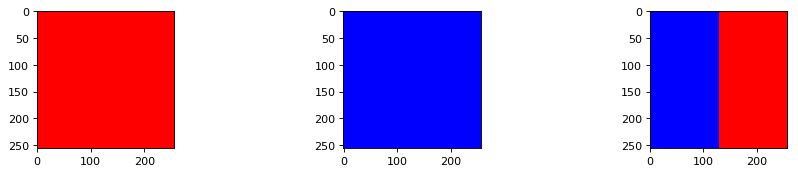

1.jpg                             2.jpg                             3.jpg                             
- red mean           255.00       - red mean             0.00       - red mean           127.50       
- green mean           0.00       - green mean           0.00       - green mean           0.00       
- blue mean            0.00       - blue mean            0.00       - blue mean            0.00       


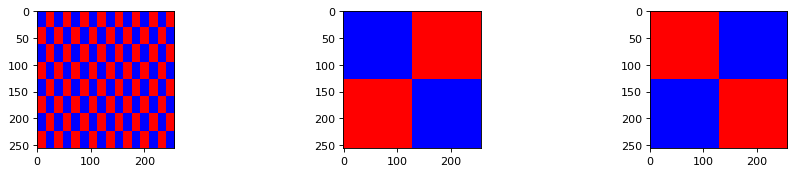

4.jpg                             5.jpg                             6.jpg                             
- red mean           127.50       - red mean           127.50       - red mean           127.50       
- green mean           0.00       - green mean           0.00       - green mean           0.00       
- blue mean            0.00       - blue mean            0.00       - blue mean            0.00       


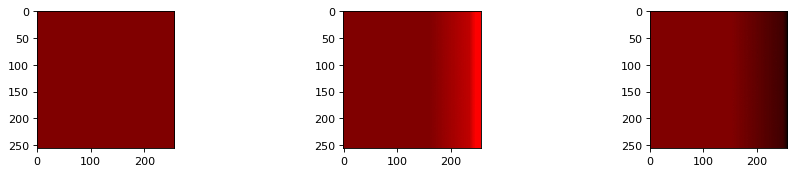

7.jpg                             8.jpg                             9.jpg                             
- red mean           128.00       - red mean           146.12       - red mean           112.66       
- green mean           0.00       - green mean           0.00       - green mean           0.00       
- blue mean            0.00       - blue mean            0.00       - blue mean            0.00       


In [5]:
featuresNames_MeanColors = ["red mean", "green mean", "blue mean"]

# TODO 
def featuresExtractor_MeanColors(image):
    values = [np.mean(image[:,:,0]),0,0]
    return values
    
e1 = Exercise("exercise1/intro/", featuresNames_MeanColors, featuresExtractor_MeanColors)
e1.display(scale = 1.0)

1.2) The second color moment is a standard deviation. Complete the feturesExtractor_StdColors method so that it computes and returns a 3-element feature vector which containts the standard deviation of the red, green, and blue color (use np.std()). Run the script and analyse the results: <br><br>
   i) Why are all the feature vectors of the images 1.jpg-2.jpg the same (and equal to zero)?<br>
   ii) Why are all the feature vectors of the images 3.jpg-6.jpg the same? <br>

In [ ]:
featuresNames_StdColors = ["red std", "green std", "blue std"]

# TODO
#def featuresExtractor_StdColors(image):
    #values = []
    #return values
    
e1 = Exercise("exercise1/intro/", featuresNames_StdColors, featuresExtractor_StdColors)
e1.display(scale = 1.0)

1.3) The third color moment is a skeweness. The skeweness measures how asymmetric is the distribution (positive value = the right tail of the distribution is longer; negative value = the left tail of the distribution is longer).  Complete the feturesExtractor_SkewColors method so that it computes and returns a 3-element feature vector containing skeweness of the red, green, and blue color (use skew() + you must transform numpy array to 1-D array; use .ravel() ). Run the script and analyse the results: <br>
    i) Why are all the feature vectors of images 1.jpg-6.jpg the same (and all the values equal to zero)?<br>
   ii) Why is the skeweness of the distribution of the red color in image 8.jpg positive but in image 9.jpg is negative? <br>

In [ ]:
featuresNames_SkewColors = ["red skew", "green skew", "blue skew"]

# TODO
#def featuresExtractor_SkewColors(image):
#    values = [skew(image.img[:,:,0].ravel(), 0, 0 ]
#    return values
    
e1 = Exercise("exercise1/intro/", featuresNames_SkewColors, featuresExtractor_SkewColors)
e1.display(scale = 1.0)

1.4) Run the below script. This example involves real pictures. Analyse the computed feature vectors (returned by featuresExtractor_MeanColor method). Can you justify the results?<br>
i) Consider the image b1_blue.jpg. Which color has the greatest mean value and which has the lowest? Compare it with the image b3_blue.jpg. Which color is the most dominant one now? Can you justify the difference between these feature vectors by comparing the pictures?<br>
ii) Why are the mean values of the feature vector of the image b6_dark.jpg very low, while they are very high for the b16_white.jpg? <br>
iii) Which of these pictures is "the most red" in your opinion? Look only at the pictures. Then, check the mean value of the red color of the chosen picture. Is it the greatest among all pictures?

In [ ]:
e1 = Exercise("exercise1/base/", featuresNames_MeanColors, featuresExtractor_MeanColors)
e1.display(scale = 1.0)

1.5) Now, it is time to build a simple seach engine for finding images. Your task is to complete the cosineSimilarity method which measures similarity between the two provided feature vectors. The greater is the returned value, the greater is the similarity. As the name of the method suggests, use a cosine similarity which is the cosine of the angle between the two vectors. You can use the spatial.distance.cosine() method. However, it returns a distance (the smaller value the better), not a similarity (the greater value the better). You have to handle this issue. Then, run the script. <br><br>
Firstly, the method searchForImage loads and displays the selected query image (q1_red.jpg), and derives its feature vector (featuresExtractor_MeanColor is used to extract feature vectors). Then, images from "exercise1/base" folder are displayed in the order of similarity to the query image. Do you agree with the ranking? Why? Why not? Why is b9_night.jpg ranked better than b15_red.jpg?

In [ ]:
#def cosineSimilarity(featuresQuery, featuresImage):
#    return 1.0

e1 = Exercise("exercise1/base/", featuresNames_MeanColors, featuresExtractor_MeanColors)
e1.searchForImage("exercise1/query/", "q1_red.jpg", cosineSimilarity)

1.6) Search for the most similar images to q2_green.jpg. Verify the results.

In [ ]:
e1.searchForImage("exercise1/query/", "q2_green.jpg", cosineSimilarity)

1.7) Search for the most similar images to q3_blue.jpg. Verify the results.

In [ ]:
e1.searchForImage("exercise1/query/", "q3_blue.jpg", cosineSimilarity)

1.8) Search for the most similar images to q4_white.jpg. Verify the results.

In [ ]:
e1.searchForImage("exercise1/query/", "q4_white.jpg", cosineSimilarity)

1.9) Search for the most similar images to q5_dark.jpg. Verify the results.

In [ ]:
e1.searchForImage("exercise1/query/", "q5_dark.jpg", cosineSimilarity)

1.10) You should find the results for the query image = q5_dark.jpg not satisfactory. What is the reason? <br>
Now, use another function of similarity. Use euclidean distance to compute similarity between the two feacture vectors. You can use spatial.distance.euclidean() method but remember that it returns a distance, not a similarity. 

In [ ]:
# TODO
#def euclideanSimilarity(featuresQuery, featuresImage):
#    return 1.0

1.11) Search for the most similar images to q5_dark.jpg using euclideanSimilarity method. Do you find the results much better?

In [ ]:
e1.searchForImage("exercise1/query/", "q5_dark.jpg", euclideanSimilarity)

1.12) Do the same for query image "q4_white.jpg". Why are the results not satisfactory?

In [ ]:
e1.searchForImage("exercise1/query/", "q4_white.jpg", euclideanSimilarity)

# Exercise 2: Shapes + Centroid + Moment Invariants + Hu Moments

2.1) In Exercise 1 you have derived image properties based on its color. Apart from the color, one may analyse a shape of an object (objects) contained in the picture. The measures which account for this are called image moments. Via image moments one may derive, e.g, an area, a total intensity, or a centroid of an object. However, it is important to remember that a segmentation of the image must be performed first in order to extract objects from the image.
<br><br>
In this exercise you are asked to compute centroids of the red, green, and blue color components. Use center_of_mass() method. It returns a pair of values [row - y coordinate, column - x coordinate] for a given matrix. Run the script and analyse the results: <br>
    i) What is the difference between the centroid of the red color and the centroid of the blue color for image 3.jpg?<br>
   ii) Why are the centroids of the red and the blue color the same for images 4.jpg-6.jpg? <br>
   iii) Considering images 7.jpg-9.jpg, why is "red x" the greatest for the image 8.jpg and is the smallest for the image 9.jpg?

In [ ]:
#centroid
featuresNames_CentroidColors = ["red x", "red y",
                 "green x", "green y",
                 "blue x", "blue y"]

# TODO
#def featuresExtractor_CentroidColors(image):
#    values = []
#    return values
    
e2 = Exercise("exercise1/intro/", featuresNames_CentroidColors, featuresExtractor_CentroidColors)
e2.display(scale = 1.0)

2.2) Some properties of the image (object) which may be found via image moments are called invariants. Moment invariants are properties of the object which do not change with respect to some specific tranformations, e.g., a translation, a scale, or a rotation. Execute the below code. All of the displayed pictures contain the same object. Yet, the difference is that location, size, and orientation of this object is different from one picture to another.

In [ ]:
scale = 1.0
figure(figsize=(9.0 * scale, 4.0 * scale), dpi=80)
subplot(2, 2, 1); plt.imshow(io.imread("exercise2/base/hu1.jpg")) 
subplot(2, 2, 2); plt.imshow(io.imread("exercise2/base/hu2.jpg")) 
subplot(2, 2, 3); plt.imshow(io.imread("exercise2/base/hu3.jpg")) 
subplot(2, 2, 4); plt.imshow(io.imread("exercise2/base/hu4.jpg")) 
plt.show()

2.2) Hu moments is a vector of 7 values which are invariant (as a vector) with respect to translation, scale, and rotation. It means that Hu moments derived from the above images should be the same. In this Exercise you are asked to complete featuresExtractor_Hu method which has to return Hu moments for a given input image. As you may notice, this image is firstly converted to the grayscale and, later, the computed Hu moments are normalised (lambda function). To compute Hu Moments (hu = [ ]) you have to, step by step:<br>
1) Compute raw moments (method moments())<br>
2) Compute central moments (method moments_central())<br>
3) Compute normalized moments (method moments_normalised())<br>
4) Compute Hu moments (method moments_hu())<br>
See the documentation of the scikit package (module measure) for a detailed information about how to use the above methods.

In [ ]:
norm = lambda x: -np.sign(x)*np.log10(np.abs(x))

featuresNames_Hu = ["hu1", "hu2", "hu3","hu4", "hu5", "hu6","hu7"]

# TODO
#def featuresExtractor_Hu(image):
#    img = rgb2gray(image)
#    hu = []
#    l = [norm(f) for f in hu]
#    return l
    
e2 = Exercise("exercise2/base/", featuresNames_Hu, featuresExtractor_Hu)

2.3) Search for the most similar images to q1.jpg. Verify the results (you can use the cosineSimilarity method). Why are some of the computed Hu moments different from one image to another (these images which contain the same object), while they should not?

In [ ]:
e2.searchForImage("exercise2/query/", "q1.jpg", cosineSimilarity)

2.4) Repeat the previous task for query = q2.jpg.

In [ ]:
e2.searchForImage("exercise2/query/", "q2.jpg", cosineSimilarity)

# Exercise 3: Texture + Gabor's Filter

3.1) Apart from the color and the shape, a texture is an important characteristic of an object/image. Run the below code. In this Exercise you are asked to implement simple search engine based on Gabor's filter. Gabor's filter is a linear filter used for texture analysis. It can be applied to an image to detect specyfic frequency content (pattern). This involves different frequencies as well as the sizes of this content. Gabor's filter is a Gaussian kernel function modulated by a sinusoidal wave. Look at the below figures. They illustrate several Gabor's filters which are different with repect to the orientation (angle) and the frequency. You may change the values of angles and freqs arrays and run the script again to see the results. However, restore their original values for the remainder of this exercise. 

In [ ]:
std = 10.0

#angles = [0, 30, 60, 90]
#freqs = [0.03, 0.05, 0.07, 0.09]
angles = [0, 30, 60, 90]
freqs = [0.03, 0.05, 0.07, 0.09]

scale = 1.0
kernels = []

for angle in angles:
    kernels_row = []
    figure(figsize=(14.0 * scale, 4.0 * scale), dpi=80)
    num = 0
    for freq in freqs:
        num += 1
        kernel = np.real(gabor_kernel(freq, theta=angle / 90.0 * 0.5 * np.pi, sigma_x=std, sigma_y=std))
        kernels_row.append(kernel)
        subplot(1, 4, num); plt.imshow(kernel, cmap='jet', vmin=-0.002, vmax=0.002) 
        plt.colorbar(orientation='horizontal', ticks = [-0.002, 0.0, 0.002])
    kernels.append(kernels_row)
plt.show()

3.2) The above filters (kernels) are convolved with the original picture. The obtained results of the convolution are images which represents frequency contant (size, orientation, frequency) which appears in the original image. Run the below script (ignore the last image):<br><br>
i) The image b1.jpg illustrates a zebra. Do you see the pattern? <br> 
ii) The below pictures are the results of the convolution. Compare them with the previously (above) illustrated Gabor's filters (kernels). Why is the outcome of the convolution the most visible for the kernels with the lowest frequencies (0.03, 0.05) and for the kernels with the lowest angles (0.0, 30.0)? <br> 
iii) Change b1.jpg to b10.jpg. Why is the outcome equally visible for all of the considered angles? <br>

There are many ways to incorporate Gabor's filters to image recognition. Usually, feature vectors are derived directly from the outomes of the convolution and the machine learning is involved to build a prediction model. In this exercise, you are asked to use a very simple apporach rather than the machine learning. Your task is to aggregate the outcomes of the convolution in order to generate a single image which represents frequency content detected in the original image. For that purpose, complete the three TODOs in the below code such that an averaged outcome of the img_convolve outcomes is generated. Run the script again and the the results (last image).

In [ ]:
image = rgb2gray(io.imread("exercise3/base/b1.jpg"))
io.imshow(image)

# TODO: init sum_image with zeros (np. zero). The matrix must be of a proper size (image.shape)
# sum_image = []

for row in kernels:
    figure(figsize=(14.0 * scale, 4.0 * scale), dpi=80)
    num = 0
    for kernel in row:
        num += 1
        img_convolve = fftconvolve(image, kernel, mode='same')  
    
        # TODO
        # add img_convovle to sum_image
        # sum_image = 
        
        subplot(1, 4, num); plt.imshow(img_convolve, cmap='jet', vmin=0.0, vmax=0.5) 
        plt.colorbar(orientation='horizontal', ticks=[0.0, 0.5])
        
# TODO compute the averaged values (divide sum_image by the number of kernels = 16)
averaged_image = [[1]]

plt.show()
figure(figsize=(4.0 * scale, 4.0 * scale), dpi=80)
subplot(1, 1, 1); plt.imshow(averaged_image, cmap='jet', vmin=0.0, vmax=0.5) 
plt.colorbar(orientation='horizontal', ticks=[0.0, 0.25, 0.5])
plt.show()

3.3) Complete the applyGaborsFilters method such that it returns an averaged image (outcomes of convolution; you can just copy the code you finished in the previous step).

In [ ]:
# TODO
#def applyGaborsFilters(image):
#    return []

3.4) Run the below script and analyse the results of applyGaborsFilters() method for different images. Consider the images with the stripes and these without the stripes (grain). These are the two textures which are considered in this exercise. What measure (mean, std, e.t.) may give different results for these two textures and may be used as a measure of similarity?

In [ ]:
def displayGabors():
    scale = 1.0
    collection1 = io.imread_collection("exercise3/base/*.jpg") 
    collection2 = io.imread_collection("exercise3/query/*.jpg")  
    images1 = [collection1[i] for i in range(0, len(collection1))]
    images2 = [collection2[i] for i in range(0, len(collection2))]
    images = images1 + images2
    for image in images:
        figure(figsize=(10.0 * scale, 5.0 * scale), dpi=80)
        gabor_image = applyGaborsFilters(image)
        subplot(1, 2, 1); plt.imshow(image) 
        subplot(1, 2, 2); plt.imshow(gabor_image, cmap='jet', vmin=0.0, vmax=0.5)
        plt.show()
displayGabors()

3.5) In this exercise you are asked to make a simple search engine for finding images based on the texture. For this purpose:<br><br>
i) Complete the featuresExtractor_Texture method. Firstly, it should use applyGaborsFilters method to generate an anverge outcome of the convolution for 16 Gabor's filters which were previously generated. Then, the method should return a feature vector consisting of the mean, the standard deviation, the skeweness, and the kurtosis of values of the generated image. The kurtosis is a fourth color moment and it measures how flat (or tall) the distribution is in comparison to normal distribution.   <br>
ii) Complete the weightedSumSimilarity method. It should compute a weighted sum of the absolute values of the differences between the values of the subsequent characteristics (features). Remember that the smaller is that sum the greater is the similarity but the method expects that with the greater similarity the greater is the outcome.  <br>
<br>
Run the below four scripts and analyse the results. Do you find them satisfactory? Which feature accounts for measuring similarity the most? Try to manipulate the weights in order to improve the results.

In [ ]:
featuresNames_Texture = ["Mean", "Std", "Skew","Kurt"]

# TODO
#def featuresExtractor_Texture(image):
#   img = applyGaborsFilters(image)
#   return [1]

# TODO 
#def weightedSumSimilarity(featuresQuery, featuresImage):
#    w = [1.0, 1.0, 1.0, 1.0]
#    score = 0.0
#    return score

e3 = Exercise("exercise3/base/", featuresNames_Texture, featuresExtractor_Texture)

In [ ]:
e3.searchForImage("exercise3/query/", "q1.jpg", weightedSumSimilarity)

In [ ]:
e3.searchForImage("exercise3/query/", "q2.jpg", weightedSumSimilarity)

In [ ]:
e3.searchForImage("exercise3/query/", "q3.jpg", weightedSumSimilarity)

In [ ]:
e3.searchForImage("exercise3/query/", "q4.jpg", weightedSumSimilarity)